In [485]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import random
%matplotlib inline

np.random.seed(0) 

In [490]:
def generate_data():
    x_space = np.linspace(-2, 5, 200)
    boundary = np.sin(x_space)  # decision boundary
    
    x1_points = []
    x2_points = []
    label = []

    for x in x_space:
        y = random.choice(np.linspace(-1.5, 1.5, 50))
        x1_points.append(x)
        x2_points.append(y)
        label.append(y > np.sin(x))

    X = []
    for pair in zip(x1_points, x2_points):
        X.append(pair)
    X = np.array(X)
    
    return X, label

In [491]:
X, label = generate_data()

Text(0, 0.5, 'x2')

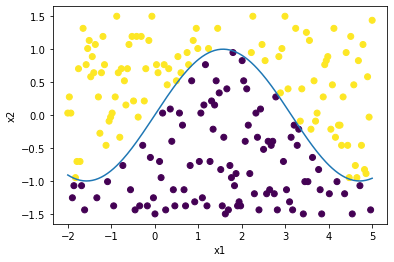

In [492]:
plt.scatter(X[:,0], X[:, 1], c=label)
plt.plot(x_space, boundary)
plt.xlabel("x1")
plt.ylabel("x2")

In [482]:
def generate_f():
    """generate a black box model f.
    """
    # black box model f
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split
    from sklearn import metrics
    
    X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.3)
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
    return clf

In [483]:
black_box_model = generate_f()

Accuracy: 0.9


In [473]:
from annoy import AnnoyIndex

ann = AnnoyIndex(2, metric="angular")  # num of features
for (i, row) in enumerate(X):
    ann.add_item(i, row)
ann.build(10)  # 10 buckets

True

In [474]:
# fetch k-nearest neighbors
n_neighbors = 25
test_idx = 10

indices = ann.get_nns_by_item(test_idx, n_neighbors)[1:]

In [475]:
# generate data to train explainable wweighted model g
X_local = []
y_local = []

for idx in indices:
    p = black_box_model.predict([X[idx]])
    y_local.append(p)
    X_local.append(X[idx])
    

In [476]:
# compute distances to weight instances
dist = []

for index in indices:
    d = np.linalg.norm(X[test_idx] - X[index])
    dist.append(1/d)  # closer instances have larger weights

In [477]:
from sklearn.linear_model import SGDClassifier

SDG = SGDClassifier(loss='log')
SDG.fit(X_local, np.array(y_local).ravel(), sample_weight=dist)  # https://stackoverflow.com/questions/7513067/weighted-logistic-regression-in-python

SGDClassifier(loss='log')

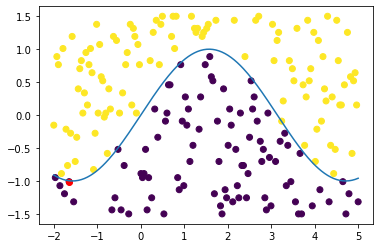

In [478]:
plt.scatter(X[:,0], X[:, 1], c=label)  # original dataset
plt.plot(X[test_idx][0], X[test_idx][1],'ro')  # test point
plt.plot(x_space, boundary)  # original decision boundary 

In [479]:
SDG.coef_

array([[-34.84198435, 137.22804372]])

In [480]:
xx, yy = np.mgrid[-2:5:.01, -2:2:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = SDG.predict_proba(grid)[:, 1].reshape(xx.shape)

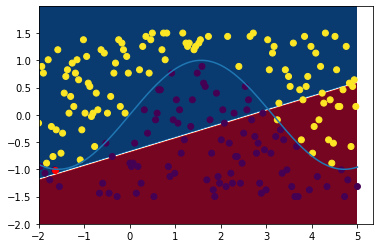

In [481]:
# plot decision boundary
f, ax = plt.subplots()
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)  # https://stackoverflow.com/questions/28256058/plotting-decision-boundary-of-logistic-regression

plt.scatter(X[:,0], X[:, 1], c=label)  # original dataset
plt.plot(X[test_idx][0], X[test_idx][1],'ro')  # test point
plt.plot(x_space, boundary)  # original decision boundary 